In [865]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import forestplot as fp
import missingno as msno
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.formula.api import glm
from statsmodels.api import qqplot
from scipy.stats import ttest_ind as t_student
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.stats import norm
from matplotlib.patches import Rectangle

In [866]:
# Chargement des données
effec1 = pd.read_csv("../csv/effec1.quest.compil.csv", encoding="ISO-8859-1")
effec2 = pd.read_csv("../csv/effec2.quest.compil.csv", encoding="ISO-8859-1")
effec3 = pd.read_csv("../csv/effec3.quest.compil.csv", encoding="ISO-8859-1")
#
usage1 = pd.read_csv("../csv/usages.effec1.csv", encoding="ISO-8859-1")
usage2 = pd.read_csv("../csv/usages.effec2.csv", encoding="ISO-8859-1")
usage3 = pd.read_csv("../csv/usages.effec3.csv", encoding="ISO-8859-1")

In [867]:
usage3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 76 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Student_ID             3883 non-null   int64  
 1   Exam.score             843 non-null    float64
 2   Exam.bin               3883 non-null   int64  
 3   Assignment.score       838 non-null    float64
 4   Assignment.bin         3883 non-null   int64  
 5   Quizz.1.score          1774 non-null   float64
 6   Quizz.1.bin            3883 non-null   int64  
 7   Quizz.2.score          1295 non-null   float64
 8   Quizz.2.bin            3883 non-null   int64  
 9   Quizz.3.score          1069 non-null   float64
 10  Quizz.3.bin            3883 non-null   int64  
 11  Quizz.4.bin            3883 non-null   int64  
 12  Quizz.4.score          973 non-null    float64
 13  Quizz.5.bin            3883 non-null   int64  
 14  Quizz.5.score          911 non-null    float64
 15  Intr

In [868]:
effec3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4233 entries, 0 to 4232
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Student_ID        3883 non-null   float64
 1   Certif.bin        3883 non-null   float64
 2   Section           1587 non-null   object 
 3   Gender            1577 non-null   object 
 4   birth.year        1543 non-null   float64
 5   Country           1575 non-null   object 
 6   Diploma           1574 non-null   object 
 7   EMLYON.et         1567 non-null   object 
 8   Formation         1562 non-null   object 
 9   CSP               1572 non-null   object 
 10  How.heard         1571 non-null   object 
 11  Exp.crea          1570 non-null   object 
 12  Curiosity.MOOC    1569 non-null   object 
 13  Certif.self.sat   1561 non-null   float64
 14  Rencontres        1551 non-null   object 
 15  Certif.work       1562 non-null   float64
 16  Incitation        1564 non-null   float64


In [869]:
usage1.head()

,Student_ID,Exam.score,Exam.bin,Assignment.score,Assignment.bin,Quizz.1.score,Quizz.1.bin,Quizz.2.score,Quizz.2.bin,Quizz.3.score,...,Post.forum.4,Post.forum.4.2,view.forum.4,view.forum.4.2,Post.forum.5,Post.forum.5.2,view.forum.5,view.forum.5.2,last.video,last.quizz
0,28,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,0,0,0,0,0,0,0,0,1,0
1,36,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,45,NaN,0,NaN,0,16.0,1,20.0,1,18.0,...,0,0,1,1,0,0,1,1,34,5
3,83,NaN,0,60.0,1,13.0,1,20.0,1,18.0,...,0,0,1,0,0,0,1,0,29,5
4,84,NaN,0,NaN,0,18.0,1,20.0,1,NaN,...,0,0,0,0,0,0,0,0,23,2


In [870]:
# Fusion des tables effec[n] et usage[n] dans des bases intermédiaires selon les identifiants des étudiants
bases_inter = []
for tabs in [(effec1, usage1), (effec2, usage2), (effec3, usage3)]:
    bases_inter.append(tabs[0].merge(tabs[1], on="Student_ID"))

In [871]:
# Concaténation des tables intermédiaires afin de créer une seule base commune
base = pd.concat(bases_inter, join="outer", 
                 axis=0, ignore_index=False, 
                 keys=[1, 2, 3])

In [872]:
base["Certif.bin"].fillna(0, inplace=True)
base = base.astype({"Exam.bin": bool, "Certif.bin": bool, "Student_ID": int})

In [873]:
base = base.copy()
# Map des modalités M et H de la variable Country_HDI
base["New_HDI"] = np.select([base["Country_HDI"] == "M", 
                             base["Country_HDI"] == "H"],
                            ["I", "I"], default=base["Country_HDI"])

In [874]:
HDI = base.groupby(["New_HDI"])[["New_HDI"]].count().rename({"New_HDI": "count"}, axis=1)

In [875]:
HDI

,count
New_HDI,
B,1032
I,667
TH,7264


In [876]:
base = base.reset_index(level=0).rename({"level_0": "Itération"}, axis=1)

In [877]:
# Nombre de catégories (videos, quiz, exam...) par apprenant par place de séquence dans la semaine pour les différentes itérations
groups = base.groupby(["Student_ID", "Itération"]).sum()

# Nombre de passages à l'examen
exam = groups[["Exam.bin"]]

# Nombre de Certifications
certif = groups[["Certif.bin"]]

# Nombre de devoirs par apprenant
devoir = groups[["Assignment.bin"]]

# Nombre de videos par apprenant par semaine pour chaque itération
week_video = [pd.DataFrame(groups.loc[:, 'S1.L1':'S1.L6'].sum(axis=1), columns=["video.S1"]),
              pd.DataFrame(groups.loc[:, 'S2.L1':'S2.L6'].sum(axis=1), columns=["video.S2"]),
              pd.DataFrame(groups.loc[:, 'S3.L1.1':'S3.L5'].sum(axis=1), columns=["video.S3"]),
              pd.DataFrame(groups.loc[:, 'S4.L1.1':'S4.L5'].sum(axis=1), columns=["video.S4"]), 
              pd.DataFrame(groups.loc[:, 'S5.L1.1':'S5.L5'].sum(axis=1), columns=["video.S5"])]

# Nombre de quiz par apprenant par semaine pour chaque itération
week_quiz = [groups[["Quizz.1.bin"]],
             groups[["Quizz.2.bin"]],
             groups[["Quizz.3.bin"]], 
             groups[["Quizz.4.bin"]], 
             groups[["Quizz.5.bin"]]]


In [878]:
# Concaténation des videos et des questionnaires de l'ensemble des semaines 
compil_week_video = pd.concat(week_video, axis=1) 
compil_week_quiz = pd.concat(week_quiz, axis=1) 

In [879]:
compil_week_video.head()

video.S1  video.S2  video.S3  video.S4  video.S5
Student_ID Itération                                                  
15         2                 2         0         0         0         0
           3                 1         0         0         0         0
28         1                 0         0         0         0         0
34         3                 0         0         0         0         0
36         1                 0         0         0         0         0

In [880]:
compil_week_quiz.head()

Quizz.1.bin  Quizz.2.bin  Quizz.3.bin  Quizz.4.bin  \
Student_ID Itération                                                       
15         2                    0            0            0            0   
           3                    0            0            0            0   
28         1                    0            0            0            0   
34         3                    0            0            0            0   
36         1                    0            0            0            0   

                      Quizz.5.bin  
Student_ID Itération               
15         2                    0  
           3                    0  
28         1                    0  
34         3                    0  
36         1                    0

In [881]:
# Nombre de videos et questionnaires par itération par apprenant pour l'ensemble du MOOC.
total_video = pd.DataFrame(compil_week_video.sum(axis=1), columns=["video"])

# Nombre de questionnaires par itération par apprenant pour l'ensemble du MOOC.
total_quiz = pd.DataFrame(compil_week_quiz.sum(axis=1), columns=["quiz"])

In [882]:
total_video.head()

video
Student_ID Itération       
15         2              2
           3              1
28         1              0
34         3              0
36         1              0

In [883]:
total_quiz.head()

quiz
Student_ID Itération      
15         2             0
           3             0
28         1             0
34         3             0
36         1             0

In [884]:
# Création de la table regroupant toutes la variables pour mesurer l'engagement de chaque apprenant pour chaque itération
total_student = pd.concat([total_video, total_quiz, devoir, exam, certif], axis=1)

In [885]:
total_student.head()

video  quiz  Assignment.bin  Exam.bin  Certif.bin
Student_ID Itération                                                   
15         2              2     0               0         0           0
           3              1     0               0         0           0
28         1              0     0               0         0           0
34         3              0     0               0         0           0
36         1              0     0               0         0           0

In [886]:
# Sélection des itérations
#total_student.xs(1, level=1)

In [887]:
# selection des types d'apprenant
def student_type(col):
    video, quiz, devoir, exam, certif = col
    if (exam >= 1 or certif >= 1):
        return "Completer"
    elif quiz > 0 and devoir > 0:
        return "Disengaging"
    elif video > 6:
        return "Auditing"
    else:
        return "Bystander"    

In [888]:
total_student["Type"] = total_student.apply(student_type, axis=1)

In [889]:
total_student.head(10)

video  quiz  Assignment.bin  Exam.bin  Certif.bin  \
Student_ID Itération                                                      
15         2              2     0               0         0           0   
           3              1     0               0         0           0   
28         1              0     0               0         0           0   
34         3              0     0               0         0           0   
36         1              0     0               0         0           0   
45         1             25     5               0         0           0   
83         1             22     5               1         0           0   
84         1              8     2               0         0           0   
87         1              1     0               0         0           0   
88         3              1     0               0         0           0   

                             Type  
Student_ID Itération               
15         2            Bystander  
           3            Bystander  
28         1            Bystander  
34         3            Bystander  
36         1            Bystander  
45         1             Auditing  
83         1          Disengaging  
84         1             Auditing  
87         1            Bystander  
88         3            Bystander

In [890]:
student = total_student.reset_index()[["Student_ID", "Type", "Itération"]]

In [891]:
student["Type"].value_counts()

Bystander      8691
Disengaging    2643
Auditing       2120
Completer      1728
Name: Type, dtype: int64

In [892]:
# Calcul du nombre d'apprenants par type et par itération
df_type = student.groupby(["Itération", "Type"])[["Type"]].count().rename({'Type': 'total'}, axis=1)

In [893]:
df_type

total
Itération Type              
1         Auditing      1207
          Bystander     4285
          Completer       20
          Disengaging   2453
2         Auditing       538
          Bystander     2168
          Completer      876
          Disengaging    120
3         Auditing       375
          Bystander     2238
          Completer      832
          Disengaging     70

In [894]:
df_type.reset_index("Type", inplace=True)

In [895]:
# Nombre total d'apprenants par itération
df_iter = df_type.groupby("Itération").sum()

In [896]:
df_iter

,total
Itération,
1,7965
2,3702
3,3515


In [897]:
total_iter = df_type.merge(df_iter, on="Itération", suffixes=["_type", "_iter"])

In [898]:
total_iter

,Type,total_type,total_iter
Itération,,,
1,Auditing,1207,7965
1,Bystander,4285,7965
1,Completer,20,7965
1,Disengaging,2453,7965
2,Auditing,538,3702
2,Bystander,2168,3702
2,Completer,876,3702
2,Disengaging,120,3702
3,Auditing,375,3515


In [899]:
# Proportion d'apprenants par types d'apprenants et par itération
total_iter["proportion/iter"] = round(total_iter["total_type"] / total_iter["total_iter"] * 100, 1)

In [900]:
total_iter

,Type,total_type,total_iter,proportion/iter
Itération,,,,
1,Auditing,1207,7965,15.2
1,Bystander,4285,7965,53.8
1,Completer,20,7965,0.3
1,Disengaging,2453,7965,30.8
2,Auditing,538,3702,14.5
2,Bystander,2168,3702,58.6
2,Completer,876,3702,23.7
2,Disengaging,120,3702,3.2
3,Auditing,375,3515,10.7


In [901]:
base["Genre"] = base["Gender"].map({"un homme": "Homme", "une femme": "Femme"})

In [902]:
# Tableau de contingence (croisement des 2 variables catégorielles)
tab_obs = pd.crosstab(index=base["Genre"], columns=base["New_HDI"])

In [903]:
tab_obs.rename(columns={"un homme": "H", "une femme": "F"}, inplace=True)

In [904]:
tab_obs

New_HDI,B,I,TH
Genre,,,
Femme,147,233,2545
Homme,883,432,4711


In [905]:
# Test d'indépendance (chi2)
chi2, p_value, degres_liberte, tableau_attendu = chi2_contingency(tab_obs)

In [906]:
tableau_attendu

array([[ 336.58250475,  217.308122  , 2371.10937325],
       [ 693.41749525,  447.691878  , 4884.89062675]])

In [907]:
chi2

179.2420322171424

In [908]:
p_value

1.196980957821505e-39

La p value est < 5% indiquerait que l'index HDI serait significativement lié au genre puisqu'il y a moins de 5 % de chance que les 2 variables soient indépendantes.

In [909]:
#residus = (tab_HDI_gender - tableau_attendu) / tableau_attendu
residus = tab_obs - tableau_attendu

In [910]:
residus

New_HDI,B,I,TH
Genre,,,
Femme,-189.582505,15.691878,173.890627
Homme,189.582505,-15.691878,-173.890627


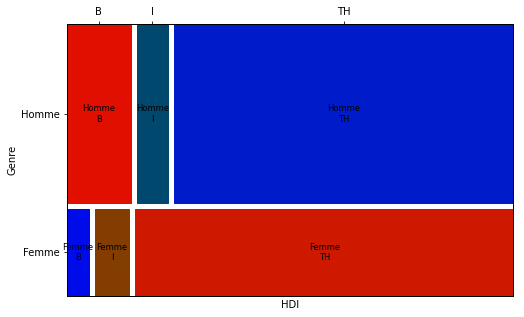

In [911]:
# Mosaic du tableau de contingence
#props = lambda key: {'color': 'red' if residus(key[0]) > 0 else 'blue'},
fig, ax = plt.subplots(figsize=(8,5))
mosaic(tab_obs.stack(), statistic=True, gap=0.02, horizontal=False, ax=ax)
ax.set_xlabel("HDI")
ax.set_ylabel("Genre")
plt.savefig("../graph/mosaic_contingence.png")
plt.show()

In [912]:
# valeurs attendues sous l'hypothèse nulle (H0).
x = tableau_attendu.flatten()

In [913]:
x

array([ 336.58250475,  217.308122  , 2371.10937325,  693.41749525,
        447.691878  , 4884.89062675])

In [914]:
# valeurs observées
y = tab_obs.stack().values

In [915]:
y

array([ 147,  233, 2545,  883,  432, 4711])

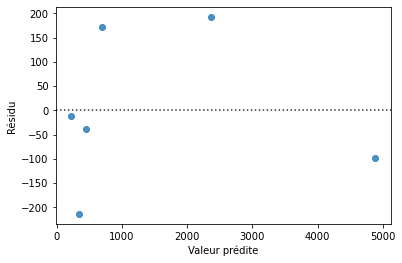

In [916]:
# Résidus du modèle de prédiction
fig, ax = plt.subplots()
sns.residplot(x=x, y=y, ax=ax)
#ax.set_title("Résidus du modèle observé")
ax.set_ylabel("Résidu")
ax.set_xlabel("Valeur prédite")
plt.savefig("../graph/residus_chi2.png")
plt.show()

fig, ax = plt.subplots()
sns.heatmap(residus, annot=True, cmap='coolwarm', cbar=True, ax=ax)
ax.set_ylabel("Genre")
ax.set_ylabel("HDI")
plt.show()

formule du V de Cramer :

V = √(χ² / (n * (min(r, c) - 1)))

Dans cette formule :

V représente le coefficient de Cramer.
χ² est la statistique du chi carré.
n est la taille de l'échantillon.
r est le nombre de niveaux ou de catégories de la première variable.
c est le nombre de niveaux ou de catégories de la deuxième variable.

In [917]:
# Fonction de calcul du V de Cramer
# data = tab ndarray
def V_Cramer(data):
    # somme de chaque colonne
    n = np.sum(data)
    # taille du tableau de contingence des variables catégorielles (taille de chaque échantillon pour chaque variable)
    row, col = tab_obs.shape
    # Formule du V de Cramer
    V = np.sqrt(chi2 / (n * (min([row, col]) - 1)))
    return V
    

In [918]:
V_Cramer(np.array(tab_obs))

0.14150902903141144

In [919]:
V_Cramer(tableau_attendu)

0.14150902903141144

La valeur V de Cramer étant faible il y a aurait une faible dépendance entre l'index HDI et le genre. Il y aurait donc statistiquement une association entre ses deux variables catégorielles, indiquée par la p-value du chi2, mais la valeur du V de Cramer indiquerait que cette dépendance serait faible. 

In [920]:
# tableau du genre par étudiant
genre_etu = base[["Student_ID", "Genre"]].drop_duplicates(subset="Student_ID").dropna()

In [921]:
genre_etu.head()

,Student_ID,Genre
1,19178,Femme
2,1086,Femme
3,1948,Femme
4,16209,Femme
5,6685,Homme


In [922]:
# Nombre total de videos par étudiant
total_video_etu = total_video.groupby("Student_ID").sum()

In [923]:
total_video_etu.head()

,video
Student_ID,
15,3
28,0
34,0
36,0
45,25


In [924]:
# tableau du genre et du nombre total de videos visionnées par étudiant
etu_genre_video = total_video_etu.merge(genre_etu, on='Student_ID')

In [925]:
etu_genre_video.head()

,Student_ID,video,Genre
0,45,25,Femme
1,83,22,Homme
2,84,8,Homme
3,87,1,Homme
4,94,2,Homme


In [926]:
# moyenne du nombre de videos visionnées par genre
total_video_etu.merge(genre_etu, on="Student_ID").groupby("Genre")[["video"]].mean()

,video
Genre,
Femme,14.855376
Homme,13.867276


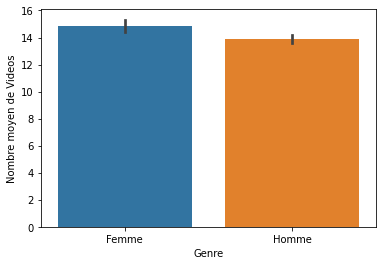

In [927]:
# Figure de la distribution du nombre de video par rapport au genre 
fig, ax = plt.subplots()
sns.barplot(data=etu_genre_video, x="Genre", y="video", ax=ax)
ax.set_xlabel("Genre")
ax.set_ylabel("Nombre moyen de Videos")
plt.savefig("../graph/mean_video.png")
plt.show()

H0 (Hypothèse nulle) : il n'y a pas de différence sur le nombre de video visionnées entre les hommes et les femmes

In [928]:
tab_stat = etu_genre_video.pivot_table(columns="Genre", index="Student_ID", values="video").fillna(0)

In [929]:
tab_stat.head()

Genre,Femme,Homme
Student_ID,,
45,25.0,0.0
83,0.0,22.0
84,0.0,8.0
87,0.0,1.0
94,0.0,2.0


In [930]:
# Test de Student
statistique, p_value = t_student(tab_stat["Homme"], tab_stat["Femme"])

In [931]:
statistique

26.98492395204523

In [932]:
p_value

3.4121378553908065e-157

Il y a moins de 5% de chance qu'il n'y ait pas de différence du nombre de visionnages entre les femmes et les hommes. Il y aurait significativement un lien entre le nombre de visionnages et le genre.

In [933]:
# Sélection par genre
df_hom = etu_genre_video[etu_genre_video["Genre"] == "Homme"]
df_fem = etu_genre_video[etu_genre_video["Genre"] == "Femme"]

In [934]:
df_hom

,Student_ID,video,Genre
1,83,22,Homme
2,84,8,Homme
3,87,1,Homme
4,94,2,Homme
5,98,23,Homme
...,...,...,...
8807,68205,30,Homme
8808,68220,30,Homme
8809,68223,0,Homme
8811,68265,14,Homme


In [935]:
# Calcul des paramètres de la distribution normale pour chaque groupe
mu_hommes, std_hommes = np.mean(df_hom["video"]), np.std(df_hom["video"])
mu_femmes, std_femmes = np.mean(df_fem["video"]), np.std(df_fem["video"])

# Création des valeurs x pour tracer la courbe théorique
x_hommes = np.linspace(min(df_hom["video"]), max(df_hom["video"]), 100)
x_femmes = np.linspace(min(df_fem["video"]), max(df_fem["video"]), 100)

# Calcul des valeurs y correspondantes en utilisant la PDF de la distribution normale
y_hommes = norm.pdf(x_hommes, mu_hommes, std_hommes)
y_femmes = norm.pdf(x_femmes, mu_femmes, std_femmes)

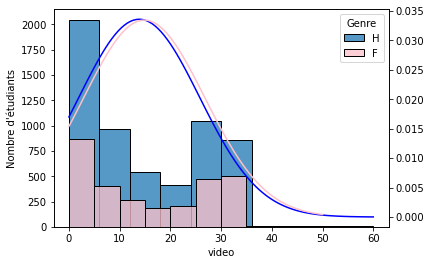

In [936]:
figure, ax1 = plt.subplots()
sns.histplot(data=df_hom, x="video", bins=10, color="tab:blue", ax=ax1, label="H")
sns.histplot(data=df_fem, x="video", bins=10, color="pink", ax=ax1, label="F")
ax1.set_xlabel("video")
ax1.set_ylabel("Nombre d'étudiants")
ax1.legend(title="Genre")
ax2 = ax1.twinx()
ax2.plot(x_hommes, y_hommes, color='blue')
ax2.plot(x_femmes, y_femmes, color='pink')
plt.savefig("../graph/distribution_video.png")
plt.show()

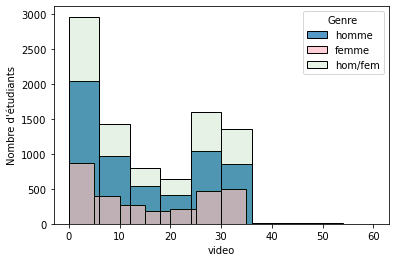

In [937]:
# visualisation de la normalité de la distribution des données (histogramme de distribution)
data = pd.concat([df_hom["video"], df_fem["video"]])
figure, ax = plt.subplots()
sns.histplot(data=df_hom, x="video", bins=10, color="tab:blue", ax=ax, label="homme")
sns.histplot(data=df_fem, x="video", bins=10, color="pink", ax=ax, label="femme")
sns.histplot(data=data, bins=10, color="green", ax=ax, label="hom/fem", alpha=0.1)
ax.set_xlabel("video")
ax.set_ylabel("Nombre d'étudiants")
ax.legend(title="Genre")
plt.savefig("../graph/distribution_video2.png")
plt.show()

La distribution des données ne suit pas une loi normale. Ce qui ne permet pas de faire un test t-Student puisque la condition première est que les données doivent être normalement distribuées.

In [938]:
# Models de regression du nombre de video selon le genre
mdl_video_vs_genre = ols("video ~ Genre", data=etu_genre_video).fit()

In [939]:
mdl_video_vs_genre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  video   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.45
Date:                Wed, 21 Jun 2023   Prob (F-statistic):           0.000247
Time:                        22:44:02   Log-Likelihood:                -34348.
No. Observations:                8818   AIC:                         6.870e+04
Df Residuals:                    8816   BIC:                         6.871e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.8554      0.221     67.365      0.000      14.423      15.288
Genre[T.Homme]    -0.9881      0.269     -3.667      0.000      -1.516      -0.460
==============================================================================
Omnibus:                    59307.238   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.417
Skew:                           0.240   Prob(JB):                    1.80e-191
Kurtosis:                       1.530   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le coefficient R² étant proche de 0, le model de régression est peu fidèle à l'observation des données. 

In [940]:
mdl_video_vs_genre.params

Intercept         14.855376
Genre[T.Homme]    -0.988100
dtype: float64

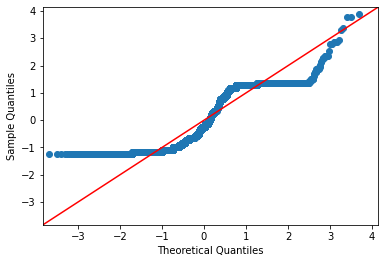

In [941]:
# Test de normalité de la distribution des données (Q-Q plot)
qqplot(data=mdl_video_vs_genre.resid, fit=True, line="45")
plt.show()

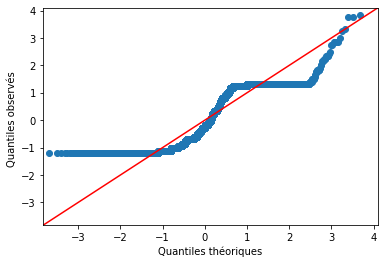

In [942]:
qqplot(data=data, fit=True, line="45")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés ")
plt.savefig("../graph/distribution_video3.png")
plt.show()

In [943]:
# Test de  Kolmogrov-Smirnov
stat, p = kstest(data, 'norm')

In [944]:
stat, p

(0.7626887430801719, 0.0)

In [945]:
# Test non paramétrique de Mann-Whitney U
mannwhitneyu(df_hom["video"], df_fem["video"])

MannwhitneyuResult(statistic=8200580.5, pvalue=0.0003907509304995919)

In [946]:
# Nombre de quiz par étudiant
total_quiz_etu = total_quiz.groupby("Student_ID").sum()

In [947]:
# Nombre de Quiz et vidéos par étudiants
video_quiz_etu = total_video_etu.merge(total_quiz_etu, on="Student_ID")

In [948]:
video_quiz_etu.loc[3139]

video    48
quiz     10
Name: 3139, dtype: int64

In [949]:
data = pd.concat([video_quiz_etu["quiz"], video_quiz_etu["video"]])

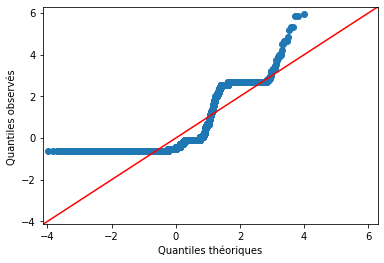

In [950]:
qqplot(data=data, fit=True, line="45")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés ")
plt.savefig("../graph/distribution_video4.png")
plt.show()

In [951]:
# Test de Pearson
correlation, p_value = pearsonr(video_quiz_etu["quiz"], video_quiz_etu["video"])

In [952]:
correlation, p_value

(0.8036026075037674, 0.0)

In [953]:
# Test de Spearman
correlation, p_value = spearmanr(video_quiz_etu["quiz"], video_quiz_etu["video"])

In [954]:
correlation, p_value

(0.804511796629543, 0.0)

Il y a une forte corrélation (0.8) entre le nombre de videos vues et le nombre de quiz réalisés par un étudiant. La corrélation observée est statistiquement significative (p-value=0).

In [955]:
# Modèle de regression sur le nombre de vidéos selon le nombre de quiz
mdl_video_vs_quiz = ols("quiz ~ video", data=video_quiz_etu).fit()

In [956]:
mdl_video_vs_quiz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   quiz   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 2.653e+04
Date:                Wed, 21 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:44:03   Log-Likelihood:                -24981.
No. Observations:               14557   AIC:                         4.997e+04
Df Residuals:                   14555   BIC:                         4.998e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5652      0.014     39.183      0.000       0.537       0.594
video          0.1575      0.001    162.896      0.000       0.156       0.159
==============================================================================
Omnibus:                     5315.454   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20116.783
Skew:                           1.821   Prob(JB):                         0.00
Kurtosis:                       7.461   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

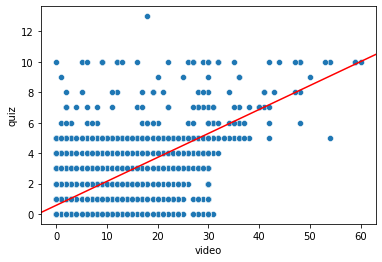

In [957]:
intercept, coef = mdl_video_vs_quiz.params
sns.scatterplot(data=video_quiz_etu, x="video", y="quiz")
plt.axline(xy1=(0,intercept), slope=coef, color="red")
plt.savefig("../graph/scatter2_regression.png")
plt.show()

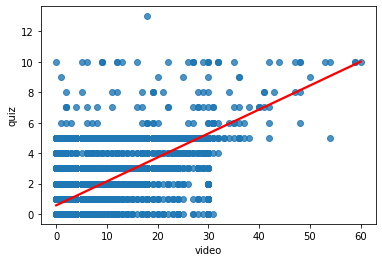

In [958]:
fig, ax = plt.subplots()
sns.regplot(data=video_quiz_etu, x=video_quiz_etu["video"], y=video_quiz_etu["quiz"], line_kws={"color": "red"}, ax=ax)
#plt.savefig("../graph/scatter_regression.png")
plt.show()

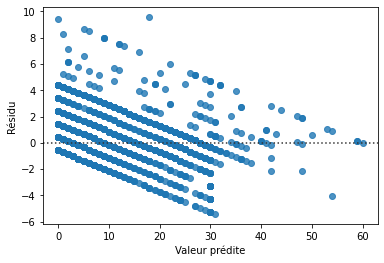

In [959]:
# Résidus du modèle de prédiction
fig, ax = plt.subplots()
sns.residplot(data=video_quiz_etu, x="video", y="quiz", ax=ax)
#ax.set_title("Résidus du modèle observé")
ax.set_ylabel("Résidu")
ax.set_xlabel("Valeur prédite")
plt.savefig("../graph/residus_regression.png")
plt.show()

In [960]:
# HDI des apprenants
student_hdi = base[["Student_ID", "New_HDI"]].dropna().set_index("Student_ID")
student_hdi.sort_values("Student_ID", inplace=True)

In [961]:
student_hdi

,New_HDI
Student_ID,
45,TH
83,I
84,B
87,TH
94,TH
...,...
68282,B
68326,TH
68332,I


In [962]:
# Tableau des 3 variables dont 2 catégorielles et 1 continue
video_genre_hdi = etu_genre_video.merge(student_hdi, on="Student_ID")

In [963]:
video_genre_hdi

,Student_ID,video,Genre,New_HDI
0,45,25,Femme,TH
1,83,22,Homme,I
2,84,8,Homme,B
3,87,1,Homme,TH
4,94,2,Homme,TH
...,...,...,...,...
8860,68282,1,Homme,B
8861,68326,30,Femme,TH
8862,68332,4,Femme,I
8863,68365,0,Femme,TH


In [964]:
# Modèle linéaire sans interaction(genre, HDI, video)
mdl1 = ols("video ~ C(Genre) + C(New_HDI)", data=video_genre_hdi).fit()

In [965]:
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  video   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     177.2
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          1.41e-111
Time:                        22:44:04   Log-Likelihood:                -34351.
No. Observations:                8865   AIC:                         6.871e+04
Df Residuals:                    8861   BIC:                         6.874e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.0011      0.432     16.211      0.000       6.155       7.848
C(Genre)[T.Homme]    -0.0959      0.267     -0.360      0.719      -0.618       0.427
C(New_HDI)[T.I]       4.6774      0.586      7.979      0.000       3.528       5.826
C(New_HDI)[T.TH]      8.6728      0.395     21.937      0.000       7.898       9.448
==============================================================================
Omnibus:                    11867.785   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              639.581
Skew:                           0.218   Prob(JB):                    1.31e-139
Kurtosis:                       1.759   Cond. No.                         8.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [966]:
# ANOVA sans interaction
anova_table = sm.stats.anova_lm(mdl1, typ=1)

In [967]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),1.0,1.554895e+03,1554.895102,11.437356,7.229351e-04
C(New_HDI),2.0,7.071483e+04,35357.416782,260.078874,1.738249e-110
Residual,8861.0,1.204643e+06,135.948823,NaN,NaN


In [968]:
# Modèle de regression avec interaction
mdl2 = ols("video ~ C(Genre)*C(New_HDI)", data=video_genre_hdi).fit()

In [969]:
mdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  video   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     107.8
Date:                Wed, 21 Jun 2023   Prob (F-statistic):          7.64e-111
Time:                        22:44:04   Log-Likelihood:                -34347.
No. Observations:                8865   AIC:                         6.871e+04
Df Residuals:                    8859   BIC:                         6.875e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              7.3310      0.968      7.573      0.000       5.434       9.229
C(Genre)[T.Homme]                     -0.4810      1.046     -0.460      0.646      -2.531       1.569
C(New_HDI)[T.I]                        2.7733      1.236      2.244      0.025       0.350       5.196
C(New_HDI)[T.TH]                       8.4673      0.995      8.506      0.000       6.516      10.419
C(Genre)[T.Homme]:C(New_HDI)[T.I]      2.8032      1.415      1.982      0.048       0.030       5.576
C(Genre)[T.Homme]:C(New_HDI)[T.TH]     0.1933      1.085      0.178      0.859      -1.933       2.320
==============================================================================
Omnibus:                    11724.976   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.561
Skew:                           0.217   Prob(JB):                    3.59e-139
Kurtosis:                       1.760   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [970]:
# ANOVA avec interaction
anova_table = sm.stats.anova_lm(mdl2, typ=1)

In [971]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),1.0,1.554895e+03,1554.895102,11.443839,7.204212e-04
C(New_HDI),2.0,7.071483e+04,35357.416782,260.226287,1.514733e-110
C(Genre):C(New_HDI),2.0,9.541531e+02,477.076535,3.511225,2.990187e-02
Residual,8859.0,1.203688e+06,135.871810,NaN,NaN


In [972]:
# obtention de l'examen /certification par étudiant par session, selon le genre et l'HDI
df_exam = base.groupby(["Student_ID", "Itération", "Gender", "New_HDI"])[["Exam.bin", "Certif.bin"]].sum().reset_index(["Gender", "New_HDI"])

In [973]:
df_exam.rename(columns={"Exam.bin": "Exam", "Certif.bin": "Certif"}, inplace=True)

In [974]:
df_exam

,,Gender,New_HDI,Exam,Certif
Student_ID,Itération,,,,
45,1,une femme,TH,0,0
83,1,un homme,I,0,0
84,1,un homme,B,0,0
87,1,un homme,TH,0,0
94,1,un homme,TH,0,0
...,...,...,...,...,...
68282,3,un homme,B,0,0
68326,3,une femme,TH,1,0
68332,3,une femme,I,1,1


In [975]:
# Obtention de l'examen et/ou de la certifcation
df_exam["Exam_Certif"] = df_exam["Exam"] | df_exam["Certif"]

In [976]:
# Obtention ou non par itération
df_exam_v1 = df_exam.xs(1, level="Itération")
df_exam_v2 = df_exam.xs(2, level="Itération")
df_exam_v3 = df_exam.xs(3, level="Itération")

In [977]:
# Generalized Linear Models (Formula du GLM)
formula = "Exam_Certif ~ Gender + New_HDI"

In [978]:
# Modèle logistic (GLM) de type binomial (variable dépendante binaire)
model = []
for n, version in enumerate([df_exam_v1, df_exam_v2, df_exam_v3]):
    model.append(glm(formula=formula, data=version, family=sm.families.Binomial()))

In [979]:
# résultats de la fonction logistic par itération
result_v1 = model[0].fit()
result_v2 = model[1].fit()
result_v3 = model[2].fit()

In [980]:
result_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Exam_Certif   No. Observations:                 5237
Model:                            GLM   Df Residuals:                     5233
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -128.64
Date:                Wed, 21 Jun 2023   Deviance:                       257.28
Time:                        22:44:05   Pearson chi2:                 4.84e+03
No. Iterations:                    25   Pseudo R-squ. (CS):           0.001021
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.9120      0.715     -8.266      0.000      -7.314      -4.510
Gender[T.une femme]     0.6235      0.456      1.367      0.172      -0.270       1.517
New_HDI[T.I]          -20.8950   1.75e+04     -0.001      0.999   -3.43e+04    3.42e+04
New_HDI[T.TH]           0.2241      0.756      0.297      0.767      -1.257       1.705
=======================================================================================
"""

In [981]:
mooc = ["V1", "V2", "V3"]

In [982]:
result_v1.params

Intercept              -5.912033
Gender[T.une femme]     0.623483
New_HDI[T.I]          -20.894989
New_HDI[T.TH]           0.224113
dtype: float64

In [983]:
# Calcul des odds-ratio, p-value et ci pour chaque itération
full_odds_r, full_pvalues, full_ci = [], [], []
for n, version in enumerate([result_v1, result_v2, result_v3]):
    # OR
    odds = np.exp(version.params).round(3)
    odds_r = odds / odds["Intercept"]
    odds_r.name = mooc[n]
    full_odds_r.append(odds_r)
    # p-value
    p_values = version.pvalues.round(3)
    p_values.name = mooc[n]
    full_pvalues.append(p_values)
    # interval de confiance (ci)
    ci = version.conf_int(alpha=0.05) # intervalle à 95 %
    sup = np.exp(ci[1]) / np.exp(ci.loc["Intercept", 0]) 
    inf = np.exp(ci[0]) / np.exp(ci.loc["Intercept", 1])
    ci = "[" + inf.round(3).astype(str) + ", " + sup.round(3).astype(str) + "]"
    ci.name = mooc[n]
    full_ci.append(ci)

In [984]:
tab_coef = pd.concat([pd.DataFrame(full_odds_r).T, pd.DataFrame(full_pvalues).T, pd.DataFrame(full_ci).T])

In [985]:
tab_coef

,V1,V2,V3
Intercept,1.0,1.0,1.0
Gender[T.une femme],621.666667,2.32574,0.641167
New_HDI[T.I],0.0,2.382688,0.837539
New_HDI[T.TH],417.0,3.548975,0.658517
Intercept,0.0,0.0,0.157
Gender[T.une femme],0.172,0.826,0.053
New_HDI[T.I],0.999,0.849,0.813
New_HDI[T.TH],0.767,0.004,0.311
Intercept,"[0.061, 16.503]","[0.561, 1.783]","[0.518, 1.931]"
Gender[T.une femme],"[69.397, 6844.388]","[1.451, 3.721]","[0.374, 1.099]"


In [986]:
index = pd.MultiIndex.from_arrays([["odds-ratio", "odds-ratio", "odds-ratio", "odds-ratio", 
                                    "p-value", "p-value", "p-value", "p-value", 
                                    "ci", "ci", "ci", "ci"], 
                                    tab_coef.index], names=["type", "coef"])

In [987]:
tab_full = pd.DataFrame({"V1": list(tab_coef["V1"]), "V2": list(tab_coef["V2"]), "V3": list(tab_coef["V3"])}, index=index)

In [988]:
tab_full.sort_index(inplace=True)

In [989]:
tab_full

V1              V2  \
type       coef                                                      
ci         Gender[T.une femme]  [69.397, 6844.388]  [1.451, 3.721]   
           Intercept               [0.061, 16.503]  [0.561, 1.783]   
           New_HDI[T.I]                 [0.0, inf]   [1.125, 5.04]   
           New_HDI[T.TH]        [25.872, 8259.698]  [1.959, 6.424]   
odds-ratio Gender[T.une femme]          621.666667         2.32574   
           Intercept                           1.0             1.0   
           New_HDI[T.I]                        0.0        2.382688   
           New_HDI[T.TH]                     417.0        3.548975   
p-value    Gender[T.une femme]               0.172           0.826   
           Intercept                           0.0             0.0   
           New_HDI[T.I]                      0.999           0.849   
           New_HDI[T.TH]                     0.767           0.004   

                                            V3  
type       coef                                 
ci         Gender[T.une femme]  [0.374, 1.099]  
           Intercept            [0.518, 1.931]  
           New_HDI[T.I]         [0.367, 1.907]  
           New_HDI[T.TH]        [0.334, 1.297]  
odds-ratio Gender[T.une femme]        0.641167  
           Intercept                       1.0  
           New_HDI[T.I]               0.837539  
           New_HDI[T.TH]              0.658517  
p-value    Gender[T.une femme]           0.053  
           Intercept                     0.157  
           New_HDI[T.I]                  0.813  
           New_HDI[T.TH]                 0.311

p > 0.05 : Non significatif (pas d'astérisque)
0.01 < p ≤ 0.05 : * (un astérisque)
0.001 < p ≤ 0.01 : ** (deux astérisques)
p ≤ 0.001 : *** (trois astérisques)

In [990]:
# Extraction des intervalles de confiance (CI) et odds-ratio pour les différentes version V1, V2 et V3
ci_v1 = pd.DataFrame(tab_full.loc[("ci", "Gender[T.une femme]"):("ci", "New_HDI[T.TH]"), "V1"]) 
or_v1 = pd.DataFrame(tab_full.loc[("odds-ratio", "Gender[T.une femme]"):("odds-ratio", "New_HDI[T.TH]"), "V1"])
pval_v1 = pd.DataFrame(tab_full.loc[("p-value", "Gender[T.une femme]"):("p-value", "New_HDI[T.TH]"), "V1"])

ci_v2 = pd.DataFrame(tab_full.loc[("ci", "Gender[T.une femme]"):("ci", "New_HDI[T.TH]"), "V2"])
or_v2 = pd.DataFrame(tab_full.loc[("odds-ratio", "Gender[T.une femme]"):("odds-ratio", "New_HDI[T.TH]"), "V2"])
pval_v2 = pd.DataFrame(tab_full.loc[("p-value", "Gender[T.une femme]"):("p-value", "New_HDI[T.TH]"), "V2"])

ci_v3 = pd.DataFrame(tab_full.loc[("ci", "Gender[T.une femme]"):("ci", "New_HDI[T.TH]"), "V3"])
or_v3 = pd.DataFrame(tab_full.loc[("odds-ratio", "Gender[T.une femme]"):("odds-ratio", "New_HDI[T.TH]"), "V3"])
pval_v3 = pd.DataFrame(tab_full.loc[("p-value", "Gender[T.une femme]"):("p-value", "New_HDI[T.TH]"), "V3"])


In [991]:
ci_v1.columns = ['CI_V1']
ci_v1.reset_index("type", drop=True, inplace=True)
or_v1.columns = ['OR_V1']
or_v1.reset_index("type", drop=True, inplace=True)
pval_v1.columns = ['pval_V1']
pval_v1.reset_index("type", drop=True, inplace=True)

In [992]:
ci_v2.columns = ['CI_V2']
ci_v2.reset_index("type", drop=True, inplace=True)
or_v2.columns = ['OR_V2']
or_v2.reset_index("type", drop=True, inplace=True)
pval_v2.columns = ['pval_V2']
pval_v2.reset_index("type", drop=True, inplace=True)

In [993]:
ci_v3.columns = ['CI_V3']
ci_v3.reset_index("type", drop=True, inplace=True)
or_v3.columns = ['OR_V3']
or_v3.reset_index("type", drop=True, inplace=True)
pval_v3.columns = ['pval_V3']
pval_v3.reset_index("type", drop=True, inplace=True)

In [994]:
# Extraction des bornes inférieure et supérieure des CI
ci_v1[["ll", "hl"]] = ci_v1["CI_V1"].str.strip("[]").str.split(",", expand=True).astype(float)
ci_v2[["ll", "hl"]] = ci_v2["CI_V2"].str.strip("[]").str.split(",", expand=True).astype(float)
ci_v3[["ll", "hl"]] = ci_v3["CI_V3"].str.strip("[]").str.split(",", expand=True).astype(float)

In [995]:
ci_v1.reset_index("coef", inplace=True)
ci_v2.reset_index("coef", inplace=True)
ci_v3.reset_index("coef", inplace=True)
or_v1.reset_index("coef", inplace=True)
or_v2.reset_index("coef", inplace=True)
or_v3.reset_index("coef", inplace=True)
pval_v1.reset_index("coef", inplace=True)
pval_v2.reset_index("coef", inplace=True)
pval_v3.reset_index("coef", inplace=True)


In [996]:
ci_v1

,coef,CI_V1,ll,hl
0,Gender[T.une femme],"[69.397, 6844.388]",69.397,6844.388
1,Intercept,"[0.061, 16.503]",0.061,16.503
2,New_HDI[T.I],"[0.0, inf]",0.000,inf
3,New_HDI[T.TH],"[25.872, 8259.698]",25.872,8259.698


In [997]:
or_v1

,coef,OR_V1
0,Gender[T.une femme],621.666667
1,Intercept,1.0
2,New_HDI[T.I],0.0
3,New_HDI[T.TH],417.0


In [998]:
pval_v1

,coef,pval_V1
0,Gender[T.une femme],0.172
1,Intercept,0.0
2,New_HDI[T.I],0.999
3,New_HDI[T.TH],0.767


In [999]:
# Tableaux des valeurs pour créer le forestplot
forest_v1 = ci_v1.merge(or_v1, on="coef").merge(pval_v1, on="coef")
forest_v2 = ci_v2.merge(or_v2, on="coef").merge(pval_v2, on="coef")
forest_v3 = ci_v3.merge(or_v3, on="coef").merge(pval_v3, on="coef")

In [1000]:
forest_v1.iloc[1, 0] = "Réf (homme/HDI B)"
forest_v2.iloc[1, 0] = "Réf (homme/HDI B)"
forest_v3.iloc[1, 0] = "Réf (homme/HDI B)"

In [1001]:
forest_v1

,coef,CI_V1,ll,hl,OR_V1,pval_V1
0,Gender[T.une femme],"[69.397, 6844.388]",69.397,6844.388,621.666667,0.172
1,Réf (homme/HDI B),"[0.061, 16.503]",0.061,16.503,1.0,0.0
2,New_HDI[T.I],"[0.0, inf]",0.000,inf,0.0,0.999
3,New_HDI[T.TH],"[25.872, 8259.698]",25.872,8259.698,417.0,0.767


In [1002]:
forest_v2

,coef,CI_V2,ll,hl,OR_V2,pval_V2
0,Gender[T.une femme],"[1.451, 3.721]",1.451,3.721,2.32574,0.826
1,Réf (homme/HDI B),"[0.561, 1.783]",0.561,1.783,1.0,0.0
2,New_HDI[T.I],"[1.125, 5.04]",1.125,5.040,2.382688,0.849
3,New_HDI[T.TH],"[1.959, 6.424]",1.959,6.424,3.548975,0.004


In [1003]:
forest_v3

,coef,CI_V3,ll,hl,OR_V3,pval_V3
0,Gender[T.une femme],"[0.374, 1.099]",0.374,1.099,0.641167,0.053
1,Réf (homme/HDI B),"[0.518, 1.931]",0.518,1.931,1.0,0.157
2,New_HDI[T.I],"[0.367, 1.907]",0.367,1.907,0.837539,0.813
3,New_HDI[T.TH],"[0.334, 1.297]",0.334,1.297,0.658517,0.311


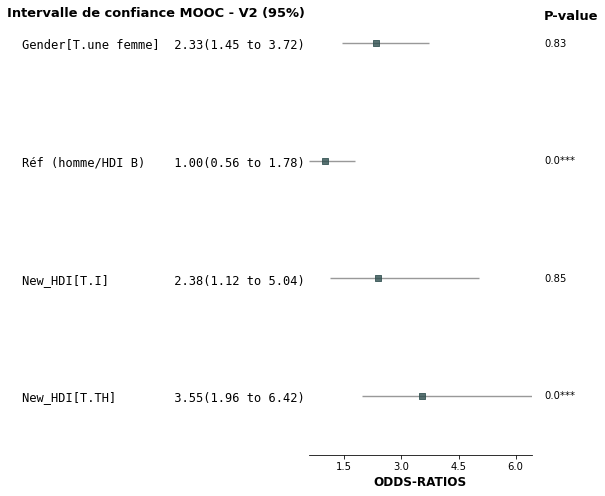

In [1004]:
fp.forestplot(forest_v2,  # the dataframe with results data
              estimate="OR_V2",  # col containing estimated effect size 
              ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
              varlabel="coef",  # column containing variable label
              pval = "pval_V2",
              #figsize = (12,16),
              ylabel="Intervalle de confiance MOOC - V2 (95%)",  # y-label title
              xlabel="ODDS-RATIOS",  # x-label title
              )
#plt.savefig("../graph/forestplot_v2.png")
plt.show()

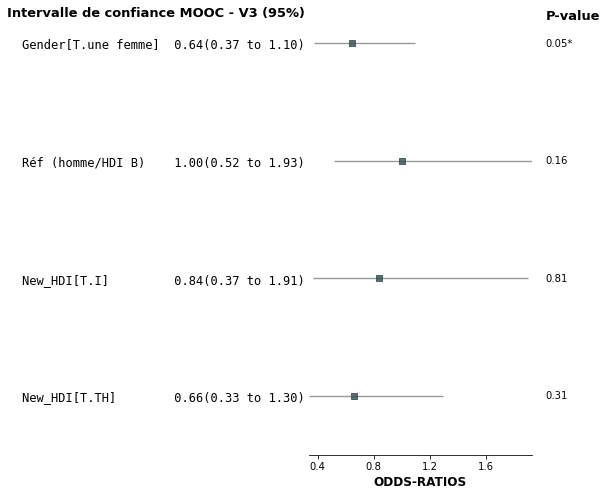

In [1005]:
fp.forestplot(forest_v3,  # the dataframe with results data
              estimate="OR_V3",  # col containing estimated effect size 
              ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
              varlabel="coef",  # column containing variable label
              pval = "pval_V3",
              ylabel="Intervalle de confiance MOOC - V3 (95%)",  # y-label title
              xlabel="ODDS-RATIOS",  # x-label title
              )
#plt.savefig("../graph/forestplot_v3.png")
plt.show()